In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lbr

In [24]:
FILE_PATH = "bell.wav"
SR = 44100
HOPSIZE = 128
WINSIZE = 512

In [16]:
sig, _ = lbr.load(FILE_PATH, sr=None)

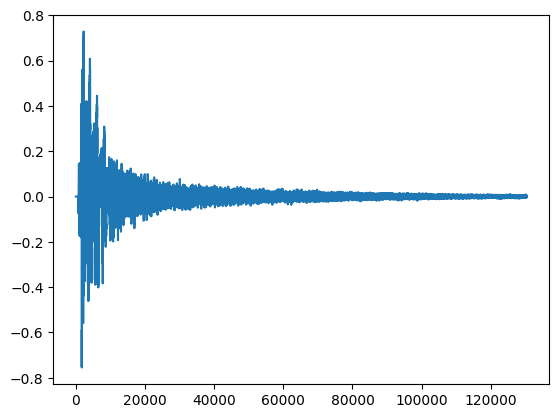

In [17]:
plt.plot(sig)
plt.show()

In [18]:
def get_rms(x: np.ndarray, win_size: int, hop_size: int) -> np.ndarray:
    n = len(x)
    rms = []
    for i in range(0, n, hop_size):
        start_index = i
        end_index = min(start_index + win_size, n)
        frame = x[start_index:end_index]
        s = np.sum(np.power(frame, 2)) / (end_index - start_index)
        rms.append(s)
    return np.sqrt(rms)

In [25]:
rms = get_rms(x=sig, win_size=WINSIZE, hop_size=HOPSIZE)

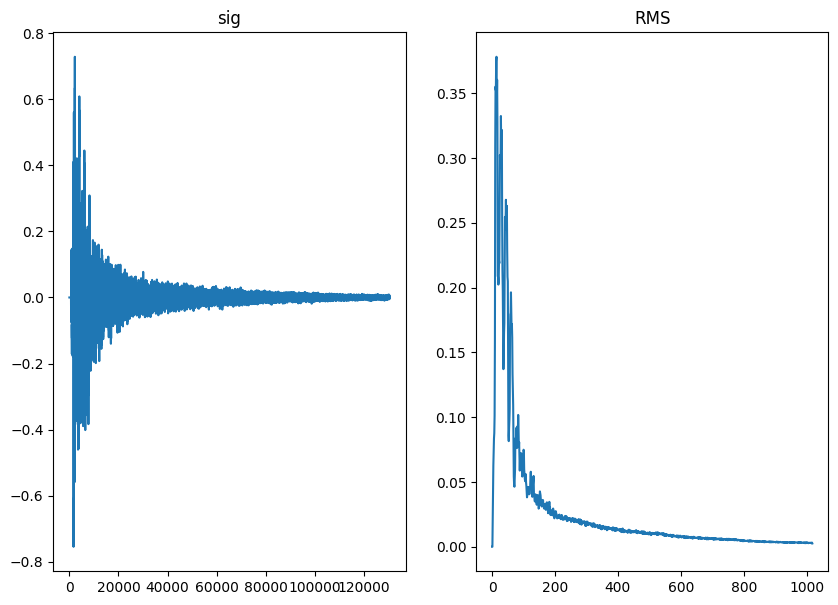

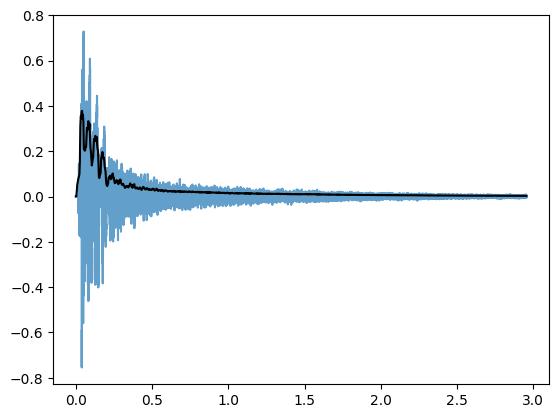

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

ax1.set_title("sig")
ax1.plot(sig)
ax2.set_title("RMS")
ax2.plot(rms)


plt.show()


trms = [i * HOPSIZE / SR for i in range(rms.size)]
tsig = np.arange(len(sig)) / SR

plt.plot(tsig, sig, alpha=0.7)
plt.plot(trms, rms, c="k")

plt.show()

In [27]:
class DelayLine():
    def __init__(self, buffer_size) -> None:
        self.buffer = np.zeros(buffer_size, dtype=np.float64)
        self.ptr = 0
    
    def read_buffer(self) -> float:
        return self.buffer[self.ptr]
    
    def write_buffer(self, value: float) -> None:
        self.buffer[self.ptr] = value
        self.ptr += 1
        self.ptr %= len(self.buffer)

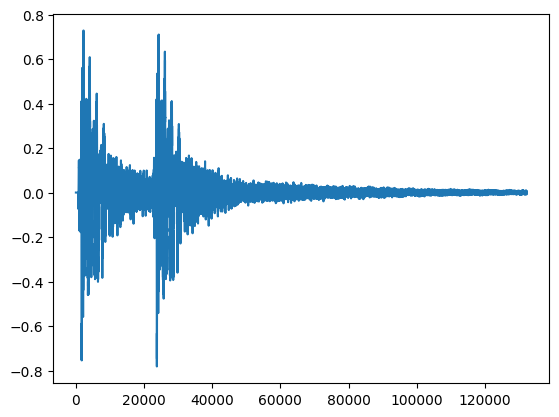

In [31]:
delay_line = DelayLine(buffer_size=22050)

y = []
dur = 3 * SR

for i in range(dur):
    read_sample = delay_line.read_buffer()
    x_sample = sig[i] if i < sig.size else 0.0
    y.append(read_sample + x_sample)
    delay_line.write_buffer(x_sample)
    
plt.plot(y)

In [32]:
from IPython.display import Audio

Audio(y, rate=44100)

In [61]:
def smooth_env(x: np.ndarray, tau: float, sr: int) -> np.ndarray:
    n = x.size
    b = 1 - np.exp(-1 / tau * sr)
    a = 1 - b
    delay_line = DelayLine(buffer_size=1)
    y = np.zeros_like(x)
    
    for i in range(n):
        delayed_sample = delay_line.read_buffer()
        sample = b * pow(x[i], 2) + a * delayed_sample
        delay_line.write_buffer(sample)
        y[i] = sample
    
    return np.sqrt(y)       

In [65]:
se = smooth_env(x=sig, tau=1 / 10, sr=SR)

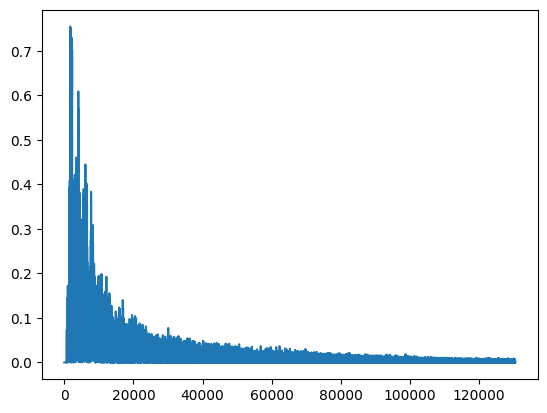

In [67]:
plt.plot(se)
plt.show()